# IMPORTS #

In [6]:
import os
import copy
import glob
import json
import h5py
import random
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
from functools import partial
from tqdm import tqdm
import enlighten
from livelossplot import PlotLosses
import math
import itertools
from matplotlib.colors import LogNorm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.utils.data import Dataset, Sampler, DataLoader, WeightedRandomSampler

torch.backends.cudnn.benchmark = True # select best performance optimization

In [7]:
torch.multiprocessing.set_start_method('spawn',force=True)
print (f"Running on GPU : {torch.cuda.is_available()}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (f"Device : {device}")


Running on GPU : True
Device : cuda:0


In [8]:
DATA = Path('/nfs/scratch/fynu/fbury/mode_workshop_data/')

Data files are in HDf5 format. The training file contains two datasets:
- `'x0'`: a set of voxelwise X0 predictions (float32)
- `'targs'`: a set of voxelwise classes (int):
    - 0 = soil
    - 1 = wall
    
The format of the datasets is a rank-4 array, with dimensions corresponding to (samples, z position, x position, y position).
All passive volumes are of the same size: 10x10x10 m, with cubic voxels of size 1x1x1 m, i.e. every passive volume contains 1000 voxels.
The arrays are ordered such that zeroth z layer is the bottom layer of the passive volume, and the ninth layer is the top layer.

Our job is to convert the X0 values into the target class values, for every voxel.

Since we want to evaluate the performance of our methods, we split off a portion of the training data to be used for validating performance, see e.g. https://www.fast.ai/2017/11/13/validation-sets/.

In [9]:
h5 = h5py.File(DATA/'train.h5', 'r')

Let's check the number of samples available:

In [10]:
h5['targs'].shape

(106129, 10, 10, 10)

So in total we have over 100,000 samples. This is quite large for the simple method we will apply, so for this tutorial we will limit ourselves to just a subsample of the data. This would also be recommended when developing more advanced methods, too, to allow us to quickly implement the method and make sure it gives reasonable results. Then the data count can be scaled up to further improve performance.

In [11]:
n = h5['targs'].shape[0]
n_train = int(0.8*n)

In [12]:
train_x = h5['x0'][:n_train]
train_y = h5['targs'][:n_train]
valid_x = h5['x0'][n_train:n]
valid_y = h5['targs'][n_train:n]

In [13]:
train_x.shape, valid_y.shape

((84903, 10, 10, 10), (21226, 10, 10, 10))

In [14]:
h5.close()


# Data viewing


In [15]:
def plot(x0:np.ndarray, targ:np.ndarray, pred:np.ndarray=None, log:bool=False, clip:float=np.inf) -> None:
    n_layers = x0.shape[0]
    n_cols = 2 if pred is None else 3
    fig, axs = plt.subplots(n_layers,n_cols,figsize=(4 * n_cols, 8*16/9))
    if n_cols == 2:
        x0_cbar_ax   = fig.add_axes([0.45, 0.25, 0.03, 0.5])
        true_cbar_ax = fig.add_axes([0.90, 0.25, 0.03, 0.5])
    else:
        x0_cbar_ax   = fig.add_axes([0.30, 0.25, 0.03, 0.5])
        true_cbar_ax = fig.add_axes([0.60, 0.25, 0.03, 0.5])
        pred_cbar_ax = fig.add_axes([0.90, 0.25, 0.03, 0.5])
        # left, bottom, width, height
    if log:
        cbar_ticks = [math.pow(10, i) 
                      for i in range(math.floor(math.log10(np.nanmin(np.clip(x0,0.,clip)))), 
                                     1+math.ceil(math.log10(np.nanmax(np.clip(x0,0.,clip)))))]
        log_norm = LogNorm(vmin = np.nanmin(np.clip(x0,0.,clip)), 
                           vmax = np.nanmax(np.clip(x0,0.,clip)))

    for layer in range(n_layers-1,-1,-1):
        # X0 #
        if log:
            sns.heatmap(np.clip(x0[layer],0.,clip), 
                    ax      = axs[n_layers-layer-1,0], 
                    vmin    = np.nanmin(x0), 
                    vmax    = np.nanmax(x0), 
                    cbar    = (layer==0), 
                    cbar_ax = x0_cbar_ax if layer == 0 else None, 
                    square  = True, 
                    cmap    = 'viridis',
                    norm    = log_norm, 
                    cbar_kws={"ticks": cbar_ticks})
        else:
            sns.heatmap(np.clip(x0[layer],0.,clip), 
                    ax      = axs[n_layers-layer-1,0], 
                    vmin    = np.nanmin(x0), 
                    vmax    = np.nanmax(x0), 
                    cbar    = (layer==0), 
                    cbar_ax = x0_cbar_ax if layer == 0 else None, 
                    square  = True, 
                    cmap    = 'viridis')
        # True walls #
        sns.heatmap(targ[layer], 
                    ax      = axs[n_layers-layer-1,1], 
                    vmin    = np.nanmin(targ), 
                    vmax    = np.nanmax(targ), 
                    cbar    = (layer==0), 
                    cbar_ax = true_cbar_ax if layer == 0 else None, 
                    square  = True, 
                    cmap    = 'viridis')
        # Predicted walls #
        if pred is not None:
            sns.heatmap(pred[layer], 
                        ax      = axs[n_layers-layer-1,2], 
                        vmin    = np.nanmin(pred), 
                        vmax    = np.nanmax(pred), 
                        cbar    = (layer==0), 
                        cbar_ax = pred_cbar_ax if layer == 0 else None, 
                        square  = True, 
                        cmap    = 'viridis')
        axs[n_layers-layer-1][0].set_ylabel(f"Layer {layer}")
    axs[-1][0].set_xlabel("X0")
    axs[-1][1].set_xlabel("Target")
    if pred is not None:
        axs[-1][2].set_xlabel("Prediction")
    plt.show()

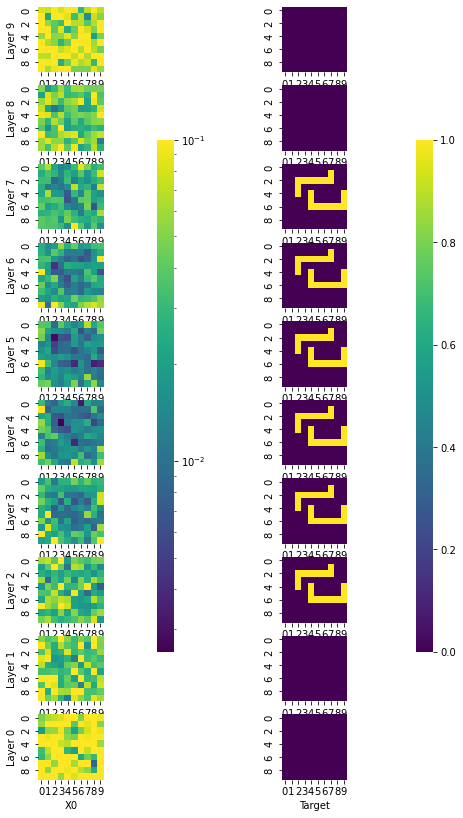

In [16]:
idx = 1
plot(train_x[idx], train_y[idx], log=True, clip=0.1)

In [17]:
def binary_iou(preds:np.ndarray, targs:np.ndarray, as_mean:bool=True, smooth:float=1e-17) -> float:
    r'''
    Assumes that preds and targs have a batch dimension, and no class dimension, i.e. (batch, z, x, y)
    If the batch dimesion is missing, e.g. your are computing the IOU for a single sample,
    add it with e.g. preds[None], targs[None]
    '''
    
    preds = preds.reshape(len(preds), 1, -1).astype(bool)
    targs = targs.reshape(len(targs), 1, -1).astype(bool)
    
    inter = (preds*targs).sum(-1)
    union = (preds+targs).sum(-1)
    iou = ((inter+smooth)/(union+smooth))  # Small epsilon in case of zero union

    if as_mean: iou = iou.mean() 
    return iou

## Neural networks

In [18]:
class DNN(nn.Module):
    def __init__(self,channels_input,height_input,width_input,output_activation=nn.Sigmoid,hidden_activation=nn.ReLU,neurons=[],mean=None,std=None):
        super().__init__()
        self.mean = mean
        self.std  = std
        if len(neurons) == 0:
            raise RuntimeError('You must provide a list of number of neurons')   
            
        self.flatten = nn.Flatten(start_dim=1)
        
        N = channels_input*height_input*width_input
        self.linear = nn.Sequential(
            nn.Linear(N, neurons[0]),
            hidden_activation(True),
            *list(itertools.chain.from_iterable(itertools.zip_longest(
                    [nn.Linear(neurons[i],neurons[i+1]) for i in range(len(neurons)-1)],
                    [hidden_activation(True) for _ in range(len(neurons)-1)]))),
            nn.Linear(neurons[-1], N),
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(channels_input,height_input,width_input))
        self.output_acti = output_activation() if output_activation else None

    def forward(self, x):
        # Normalize #
        if self._mean is not None and self._std is not None:
            x = (x-self.mean)/self.std
        
        # Apply DNN #
        x = self.unflatten(self.linear(self.flatten(x)))
        if self.output_acti is not None:
            x = self.output_acti(x)
        return  x


In [19]:
# Useful functions for CNN 

# Checking arguments to the layer #

def checkArgument(arg):
    if isinstance(arg,int):
        return (arg,arg)
    elif isinstance(arg,float):
        return (int(arg),int(arg))
    elif isinstance(arg,tuple) or isinstance(arg,list):
        if len(arg) != 2:
            raise RuntimeError(f'Expected size of 2, got {len(arg)}')
        return arg
    else:
        raise RuntimeError(f'Format {type(arg)} not understood')

# Get layer output height and width #

def getEncodingLayerOutputSize(in_height,in_width,kernel_size,stride,padding,dilation,**kwargs): 
    # Make args with tuple if necessary #
    kernel_size    = checkArgument(kernel_size)
    stride         = checkArgument(stride)
    padding        = checkArgument(padding)
    dilation       = checkArgument(dilation)
    # Compute new height and width #
    h = (in_height + 2*padding[0] - dilation[0] * (kernel_size[0]-1) -1) / stride[0] + 1
    w = (in_width  + 2*padding[1] - dilation[1] * (kernel_size[1]-1) -1) / stride[1] + 1
    return int(h),int(w)

def getDecodingLayerOutputSize(in_height,in_width,kernel_size,stride,padding,output_padding,dilation,**kwargs):
    # Make args with tuple if necessary #
    kernel_size    = checkArgument(kernel_size)
    stride         = checkArgument(stride)
    padding        = checkArgument(padding)
    dilation       = checkArgument(dilation)
    output_padding = checkArgument(output_padding)
    # Get new height and width #
    h = (in_height-1)*stride[0] - 2*padding[0] + dilation[0]*(kernel_size[0]-1) + output_padding[0] + 1
    w = (in_width-1)*stride[1]  - 2*padding[1] + dilation[1]*(kernel_size[1]-1) + output_padding[1] + 1
    return int(h),int(w)

# Get coding layer #

def getEncodingLayer(in_height,in_width,in_channels,out_channels,kernel_size,stride,padding,dilation,layer_type,**kwargs):
    # Make args with tuple if necessary #
    kernel_size    = checkArgument(kernel_size)
    stride         = checkArgument(stride)
    padding        = checkArgument(padding)
    dilation       = checkArgument(dilation)
    # Get new height and width #
    out_height,out_width = getEncodingLayerOutputSize(in_height,in_width,kernel_size,stride,padding,dilation)
    # Make layer #
    if layer_type == 'conv':
        layer = nn.Conv2d(in_channels   = in_channels,
                          out_channels  = out_channels,
                          kernel_size   = kernel_size,
                          stride        = stride,
                          padding       = padding,
                          dilation      = dilation)
    elif layer_type == 'pool':
        layer = nn.MaxPool2d(kernel_size   = kernel_size,
                             stride        = stride,
                             padding       = padding,
                             dilation      = dilation,
                             return_indices= True)
    else:
        raise RuntimeError()
    # Return
    return layer,out_height,out_width

def getDecodingLayer(in_height,in_width,in_channels,out_channels,kernel_size,stride,padding,output_padding,dilation,layer_type,**kwargs):
    # Make args with tuple if necessary #
    kernel_size    = checkArgument(kernel_size)
    stride         = checkArgument(stride)
    padding        = checkArgument(padding)
    dilation       = checkArgument(dilation)
    output_padding = checkArgument(output_padding)
    # Get new height and width #
    out_height,out_width = getDecodingLayerOutputSize(in_height,in_width,kernel_size,stride,padding,output_padding,dilation)
    # Make layer #
    if layer_type == 'conv':
        layer = nn.ConvTranspose2d(in_channels    = in_channels,
                                   out_channels   = out_channels, 
                                   kernel_size    = kernel_size,
                                   stride         = stride,
                                   padding        = padding,
                                   output_padding = output_padding,
                                   dilation       = dilation)
    elif layer_type == 'pool':
        layer = nn.MaxUnpool2d(kernel_size   = kernel_size,
                               stride        = stride,
                               padding       = padding)
    else:
        raise RuntimeError()

    # Return
    return layer,out_height,out_width



In [20]:
class Encoder(nn.Module):
    def __init__(self,params,channels_input,height_input,width_input,hidden_activation,batch_norm):
        super().__init__()
        assert isinstance(params,list)
        prev_layer_channels = channels_input
        prev_layer_height   = height_input
        prev_layer_width    = width_input
        self.layers = nn.ModuleList()   
        self.architecture = []
        for i,p in enumerate(params):
            assert isinstance(p,dict)
            if p['layer_type'] == 'pool':
                p['out_channels'] = prev_layer_channels
            p.update({'in_channels'  : prev_layer_channels,
                      'in_height'    : prev_layer_height,
                      'in_width'     : prev_layer_width})
            layer,out_height,out_width = getEncodingLayer(**p)
            self.layers.append(layer)
            self.architecture.append(((prev_layer_channels,prev_layer_height,prev_layer_width),
                                      (p['out_channels'],out_height,out_width)))
                                      
            # keep in memory #
            prev_layer_channels = p['out_channels']
            prev_layer_height   = out_height
            prev_layer_width    = out_width
            
            # Additional layers #
            if p['layer_type'] != 'pool':
                if hidden_activation is not None and i < len(params):
                    self.layers.append(hidden_activation(True))
                if batch_norm and (i==len(params)-1 or params[i+1]['layer_type']!='pool'):
                    # If there is a pool layer afterwards, apply the batch norm at that stage
                    self.layers.append(nn.BatchNorm2d(p['out_channels']))
            else:
                if batch_norm:
                    self.layers.append(nn.BatchNorm2d(p['out_channels']))
        
    def forward(self,x):
        indices = []
        for layer in self.layers:
            if isinstance(layer,nn.MaxPool2d):
                x,ind = layer(x)
                indices.append(ind)
            else:
                x = layer(x)
        return x,indices
        

class Decoder(nn.Module):
    def __init__(self,params,hidden_activation,batch_norm):
        super().__init__()
        assert isinstance(params,list)
        self.layers = nn.ModuleList()  
        self.architecture = []
        for i,p in enumerate(params):
            assert isinstance(p,dict)
            if p['stride'] > 1:
                # Deconvolution with stride>1 is ambiguous, need to use output_padding to compensante
                p['output_padding'] = 0
                while getDecodingLayerOutputSize(**p) != (p['out_height'],p['out_width']):
                    p['output_padding'] += 1
                print (f'In deconvolution layer {len(params)-1-i}, compensates stride by output_padding = {p["output_padding"]}')
            layer,out_height,out_width = getDecodingLayer(**p)
            assert out_height == p['out_height']
            assert out_width  == p['out_width']
            self.layers.append(layer)
            self.architecture.append(((p['in_channels'],p['in_height'],p['in_width']),
                                      (p['out_channels'],out_height,out_width)))
            # Additional layers #
            if p['layer_type'] != 'pool':
                if hidden_activation is not None and i < len(params)-1:
                    self.layers.append(hidden_activation(True))
                if batch_norm and (i==len(params)-1 or params[i+1]['layer_type']!='pool'):
                    # If there is a pool layer afterwards, apply the batch norm at that stage
                    self.layers.append(nn.BatchNorm2d(p['out_channels']))
            else:
                if batch_norm:
                    self.layers.append(nn.BatchNorm2d(p['out_channels']))
    def forward(self,x,indices):
        idx = 0
        for layer in self.layers:
            if isinstance(layer,nn.MaxUnpool2d):
                assert torch.is_tensor(indices[idx])
                x = layer(x,indices[idx])
                idx += 1
            else:
                x = layer(x)
        return x

class CNN(nn.Module):
    def __init__(self,channels_input,height_input,width_input,DNN_params=None,output_activation=nn.Sigmoid,hidden_activation=None,parameters=[],batch_norm=False,mean=None,std=None,weights=None):
        super().__init__()
        self._mean    = mean
        self._std     = std
        self._weights = weights.to(torch.float32) if weights is not None else None
                
        if len(parameters) == 0:
            raise RuntimeError('You must provide a list of number of parameters')  
        
        default_encoder = {'kernel_size':1,'stride':1,'padding':0,'dilation':1}
        default_decoder = {'kernel_size':1,'stride':1,'padding':0,'dilation':1,'output_padding':0}

        params_encoder = []
        params_decoder = []
        
        # Make list of coder parameters #
        for i,params in enumerate(parameters):
            # Safety checks #
            assert isinstance(params,dict)
            if 'out_channels' in params:
                layer_type = 'conv'
            else:
                layer_type = 'pool'
            # Make conv layer #
            params_encoder.append({'layer_type':  layer_type, 
                                  **params,
                                  **{k:v for k,v in default_encoder.items() if k not in params}})
     
            
        # Initialize encoder #
        self.encoder = Encoder(params             = params_encoder,
                               channels_input     = channels_input,
                               height_input       = height_input,
                               width_input        = width_input,
                               hidden_activation  = hidden_activation,
                               batch_norm         = batch_norm)
        print ('Encoder architecture')
        for i,(inputArch,outputArch) in enumerate(self.encoder.architecture):
            print (f'\tLayer {i:2d} -> input  : channels = {inputArch[0]:3d}, height = {inputArch[1]:3d}, width = {inputArch[2]:3d}')
            print (f'\t         -> output : channels = {outputArch[0]:3d}, height = {outputArch[1]:3d}, width = {outputArch[2]:3d}')
        
        # Get decoder parameters #
        for p_encoder,(a_in,a_out) in zip(reversed(params_encoder),reversed(self.encoder.architecture)):
            p_decoder = {**default_decoder}
            p_decoder.update(p_encoder)
            p_decoder.update({'in_channels'    : a_out[0],
                              'in_height'      : a_out[1],
                              'in_width'       : a_out[2],
                              'out_channels'   : a_in[0],
                              'out_height'     : a_in[1],
                              'out_width'      : a_in[2]})
            params_decoder.append(p_decoder)
        # Initialize decoder #
        self.decoder = Decoder(params           = params_decoder,
                               #height_input       = height_input,
                               #width_input        = width_input,
                               hidden_activation  = hidden_activation,
                               batch_norm         = batch_norm)
        print ('Decoder architecture')
        for i,(inputArch,outputArch) in enumerate(self.decoder.architecture):
            print (f'\tLayer {i:2d} -> input  : channels = {inputArch[0]:3d}, height = {inputArch[1]:3d}, width = {inputArch[2]:3d}')
            print (f'\t         -> output : channels = {outputArch[0]:3d}, height = {outputArch[1]:3d}, width = {outputArch[2]:3d}')
        

        
        # Potential DNN #
        if DNN_params is not None:
            out_height,out_width, parameters[-1]['out_channels']
            DNN_params.update({
                    'channels_input'  : parameters[-1]['out_channels'],
                    'height_input'    : out_height,
                    'width_input'     : out_width})
            self.DNN = DNN(**DNN_params)
        else:
            self.DNN = None
        

        self.output_acti = output_activation() if output_activation else None
   
    
    def forward(self, x):
        # Normalize #
        if self._mean is not None and self._std is not None:
            x = TF.normalize(x,self._mean,self._std)
        
        # Pass through conv layers #
        x,indices = self.encoder.forward(x)
        
        # Use DNN is requested #
        if self.DNN is not None:
            x = self.DNN(x,layer)
            
        # Pass through deconv layers
        x = self.decoder(x,indices[::-1])
        
        # output #
        if self.output_acti is not None:
            x = self.output_acti(x)
            
        # Return #
        return x
    
    def predict(self,x,batch_size=None):
        """
            Use to produce the output of a tensor or a loader 
            if batch_size is provided, will produce x sequentially
            -> avoids memory issues
        """
        with torch.no_grad():
            if torch.is_tensor(x):
                if batch_size is None:
                    return self(x)
                else:
                    outputs = torch.zeros(x.shape)
                    N = math.ceil(outputs.shape[0]/batch_size)
                    for idx in tqdm(range(N)):
                        xi = idx * batch_size
                        xf = min((idx+1) * batch_size, outputs.shape[0])
                        outputs[xi:xf] = self(x[xi:xf])
                    return outputs
            elif isinstance(x,DataLoader):
                outputs = torch.zeros(x.dataset.target_shape)
                idx = 0
                for data in tqdm(x):
                    inputs = data[0]
                    outputs[idx:idx+inputs.shape[0]] = self(inputs)
                    idx += inputs.shape[0]
                return outputs
            else:
                raise RuntimeError(f'Unknown')


# Preprocessing 

In [21]:
def Augmentation(x:torch.tensor,y:torch.tensor):
    """
        Applies rotations with angles : 0°, 90°, 180° and 270°
        + vflip
        hflip is redundant
    """
    data_x = []
    data_y = []
    for angle in [0,90,180,270]:
        rotated_x = TF.rotate(x,angle)
        data_x.append(rotated_x)
        data_x.append(TF.hflip(rotated_x))
        
        rotated_y = TF.rotate(y,angle)
        data_y.append(rotated_y)
        data_y.append(TF.hflip(rotated_y))
    return torch.cat(data_x,axis=0),torch.cat(data_y,axis=0)

def AveragePredictions(net_func,x:torch.tensor):
    """
        Averages the predictions over the 8 possible permutations
        -> avoids bias in prediction
    """
    preds = []
    for angle in [0,90,180,270]:
        rotated_x = TF.rotate(x,angle)      
        preds.append(TF.rotate(net_func(rotated_x),-angle))
        preds.append(TF.rotate(TF.hflip(net_func(TF.hflip(rotated_x))),-angle))
    pred_avg = sum(preds) / len(preds)
    return pred_avg

In [22]:
# Produces the tensor with the augmentation # 

valid_x_tensor = torch.from_numpy(valid_x)#.to(device)
valid_y_tensor = torch.from_numpy(valid_y)#.to(device)

train_x_tensor = torch.zeros((train_x.shape[0]*8,train_x.shape[1],train_x.shape[2],train_x.shape[3]))
train_y_tensor = torch.zeros((train_y.shape[0]*8,train_y.shape[1],train_y.shape[2],train_y.shape[3]))

for i in tqdm(range(train_x.shape[0])):
    x,y = Augmentation(torch.from_numpy(train_x[i:i+1]),torch.from_numpy(train_y[i:i+1]))
    train_x_tensor[8*i:8*(i+1)] = x
    train_y_tensor[8*i:8*(i+1)] = y

print (f'Augmentation : from {train_x.shape[0]} to {train_x_tensor.shape[0]} [factor = {train_x_tensor.shape[0]/train_x.shape[0]:.3f}] in the training set')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84903/84903 [01:44<00:00, 812.68it/s]

Augmentation : from 84903 to 679224 [factor = 8.000] in the training set


In [23]:
class MyTransform:
    """
        Class to be used in the dataloader, that performs 
        - rotations 
        - vertical flip
        - horizontal flip
        All randomly, as data is served
        NOTE : note used in Jupyter notebook, no multiprocessing can be used, and becomes slow
    """
    def __init__(self,p_hflip=0.5,p_vflip=0.5):
        random.seed(random.randint(1,100000))
        self.angles = [0,90,180,270]
        self.angle = 0
        self.hflip = False
        self.vflip = False
        self.p_hflip = p_hflip
        self.p_vflip = p_vflip

        
    def generate(self):
        self.angle = random.choice(self.angles)
        self.hflip = random.random() <= self.p_hflip
        self.vflip = random.random() <= self.p_vflip
        
    def __call__(self, x):
        x = TF.rotate(x,self.angle)
        if self.hflip:
            x = TF.hflip(x)
        if self.vflip:
            x = TF.vflip(x)
        return x

In [24]:
# DATA LOADER
class CustomDataset(Dataset):
    """
        Custom dataset that provides inputs, targets and eventually weights
        Also can perform data augmentation through the transform object, and assing to a different device
    """
    def __init__(self, inputs:torch.tensor, targets:torch.tensor, weights:torch.tensor=None, transform=None, device=None):
        self.inputs     = inputs
        self.targets    = targets
        self.weights    = weights
        self.transform  = transform
        self.device     = device

    @property
    def input_shape(self):
        return self.inputs.shape
    
    @property
    def target_shape(self):
        return self.targets.shape

    def __len__(self):

        return self.inputs.shape[0]

    def __getitem__(self, idx):
        inp = self.inputs[idx]
        out = self.targets[idx]
        w   = None
        
        if self.weights is not None:
            w   = self.weights[idx]
            
        if self.transform:
            self.transform.generate()
            inp = self.transform(inp)
            out = self.transform(out)
            if self.weights is not None:
                w = self.transform(w)

        if self.device is not None:
            inp = inp.to(self.device)
            out = out.to(self.device)
            if self.weights is not None:
                w = w.to(self.device)
            
        if w is None:
            return inp,out
        else:
            return inp,out,w


In [25]:
### Generate dataset + loaders

batch_size = 512

transform = MyTransform()

train_dataset = CustomDataset(train_x_tensor,
                              train_y_tensor,
                              device=device)
valid_dataset = CustomDataset(valid_x_tensor,
                              valid_y_tensor,
                              device=device)
trainloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size      = batch_size,
                                          #num_workers   = 1,
                                          #pin_memory      = True,
                                          #prefetch_factor = 10,
                                          #pin_memory_device = device,
                                          #persistent_workers = True,
                                          shuffle         = True)
validloader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size    = 5000,
                                          #num_workers   = 1,
                                          #pin_memory      = True,
                                          #prefetch_factor = 10,
                                          #pin_memory_device = device,
                                          #persistent_workers = True,
                                          shuffle       = False)

print (f'Batch size  = {batch_size}, training set = {len(train_dataset)} -> {math.ceil(len(train_dataset)/batch_size)} batches')

Batch size  = 512, training set = 679224 -> 1327 batches


# Loss functions 

In [ ]:
def reshape_weights(w,shape):
    assert w.dim() < len(shape)
    if w.dim() == 2:
        return w.unsqueeze(-1).unsqueeze(-1).repeat(1,1,shape[2],shape[3])
    else:
        raise RuntimeError
        
class baseIOULoss(nn.Module):
    """
        Base class to perform the IOU loss function
    """
    def __init__(self, smooth=1e-2):
        super(baseIOULoss, self).__init__()
        self.smooth = smooth
        
    def formula(self,inputs,targets,weights,axis):
        raise NotImplementedError

    def forward(self, inputs, targets, weights=None): 
                
        #inputs = inputs.view(-1)
        #targets = targets.view(-1)
        if weights is not None:
            if weights.dim == 1:
                # Weight applied per event
                axis = [1,2,3]
                weights /= weights.sum()
            elif weights.dim == 2:
                # Weight applied to event and layers 
                axis = [2,3]
            else:
                weights = torch.tensor([1])
                axis = [0,1,2,3]
        else:
            weights = None
            axis = [0,1,2,3]
        return self.formula(inputs,targets,weights,axis)
    

class IoULoss(baseIOULoss):
    """
        Loss function of IOU, based on https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook
        IOU loss : 1 - (y.yb + epsilon) /  (y + yb - y.yb + epsilon))
    """
    
    def formula(self,inputs,targets,weights,axis):
        intersection = (inputs * targets).sum(axis=axis)
        total = (inputs + targets).sum(axis=axis)
        union = total - intersection 
      
        IOU = (intersection + self.smooth)/(union + self.smooth)
        
        if weights is not None:
            IOU = (IOU*weights).sum()
        else:
            IOU = IOU.sum()
        return 1-IOU

# Jaccard power loss : 1 - (y.yb + epsilon) /  (y^p + yb^p - y.yb + epsilon))
class PowerJaccard(baseIOULoss):
    """
        Jaccard loss : 1 - (y.yb + epsilon) /  (y**p + yb**p - y.yb + epsilon))
        yb = prediction, y = target in {0,1}
        https://www.scitepress.org/Papers/2021/103040/103040.pdf
    """
    def __init__(self, smooth=1e-2, power=1):
        super(PowerJaccard, self).__init__(smooth)
        self.power = power

    def formula(self,inputs,targets,weights,axis):
        intersection = (inputs * targets).sum(axis=axis)
        total = (inputs**self.power  + targets**self.power).sum(axis=axis)
        union = total - intersection 
      
        IOU = (intersection + self.smooth)/(union + self.smooth)
        
        if weights is not None:
            IOU = (IOU*weights).sum()
        else:
            IOU = IOU.sum()
        return 1-IOU

        

# Training 

In [27]:
class EarlyStopping():
    """
        Early stopping class
        tolerance = how many epochs before cutting the training
        min_delta = minimum to reset the counter
    """
    def __init__(self, tolerance=5, min_delta=0):
        self.prev_loss = np.inf
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0

    def __call__(self, loss):
        if (loss - self.prev_loss) > self.min_delta:
            self.counter += 1
        else:
            self.counter = 0
        self.prev_loss = loss
        return self.counter >= self.tolerance


In [28]:
def training(net,epochs,loss,optimizer,train_loader,valid_loader,metrics={},scheduler=None,early_stopping=None):
    """
        Function that performs the training
    """
    loss = copy.deepcopy(loss)
    if torch.cuda.is_available():
        loss = loss.cuda()
        
    printout_steps = 100
    printout_freq  = len(train_loader) // printout_steps

    manager = enlighten.get_manager()
    epoch_counter = manager.counter(total=epochs, desc='Epochs', unit='epoch')

    liveloss = PlotLosses()

    for epoch in range(1,epochs+1):  
        #batch_counter = manager.counter(total=printout_steps, desc=f'Batches (epoch {epoch})', unit='batch')

        logs = {**{metricName:0. for metricName in metrics.keys()},
                **{f'val_{metricName}':0. for metricName in metrics.keys()},
                'loss' : 0.,
                'val_loss' : 0.}
        
        # Training #
        net.train()    

        for i, data in enumerate(train_loader, 1):
            # get the inputs; data is a list of [inputs, labels]
            if len(data) == 2:
                inputs,labels = data
                weights = None
            elif len(data) == 3:
                inputs,labels,weights = data
            else:
                raise RuntimeError
            #layers = layers.detach().to(device)
            #inputs = inputs.to(device)
            #labels = labels.to(device)
            #weights = weights.to(device)
            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # forward + backward + optimize
            outputs = net(inputs) 
            loss_value = loss(outputs, labels.to(torch.float32), weights)
            logs['loss'] += loss_value.item()
            with torch.no_grad():
                for metricName,metric in metrics.items():
                    logs[metricName] += metric(outputs, labels.to(torch.float32)).cpu()
            
            loss_value.backward()
            optimizer.step()


            #if i % printout_freq == 0:    # print every printout_freq mini-batches
            #    batch_counter.update()
        if scheduler is not None:
            scheduler.step()

        # Validation #
        with torch.no_grad():
            net.eval()
            with torch.no_grad():
                val_outputs = []
                val_labels  = []
                val_weights = []
                for data in valid_loader:
                    if len(data) == 2:
                        inputs,labels = data
                    elif len(data) == 3:
                        inputs,labels,_ = data
                    else:
                        raise RuntimeError
                    # layers = layers.detach().to(device)
                    #inputs = inputs.to(device)
                    #labels = labels.to(device)
                    #weights = weights.to(device)
                    val_outputs.append(net(inputs))
                    val_labels.append(labels)
                    #val_weights.append(weights)
                val_outputs = torch.cat(val_outputs,axis=0)
                val_labels  = torch.cat(val_labels,axis=0)
                #val_weights  = torch.cat(val_weights,axis=0)
                
                val_loss_value = loss(val_outputs, val_labels.to(torch.float32))
                logs['val_loss'] += val_loss_value.item()
                
                for metricName,metric in metrics.items():
                    logs[f'val_{metricName}'] += metric(val_outputs, val_labels.to(torch.float32)).cpu()


        # Counter #
        #batch_counter.close()
        epoch_counter.update()
    
        # Plot
        for metricName in metrics.keys():
            logs[metricName] /= len(train_loader)
        logs['loss'] /= len(train_loader)
        logs['lr']    = optimizer.param_groups[0]['lr']
        #print (logs)
        liveloss.update(logs)
        liveloss.send()
        

        # Early stopping #
        if early_stopping is not None and early_stopping(val_loss_value):
            print ('Early stopping')
            break

    manager.stop()

    print('Finished Training')


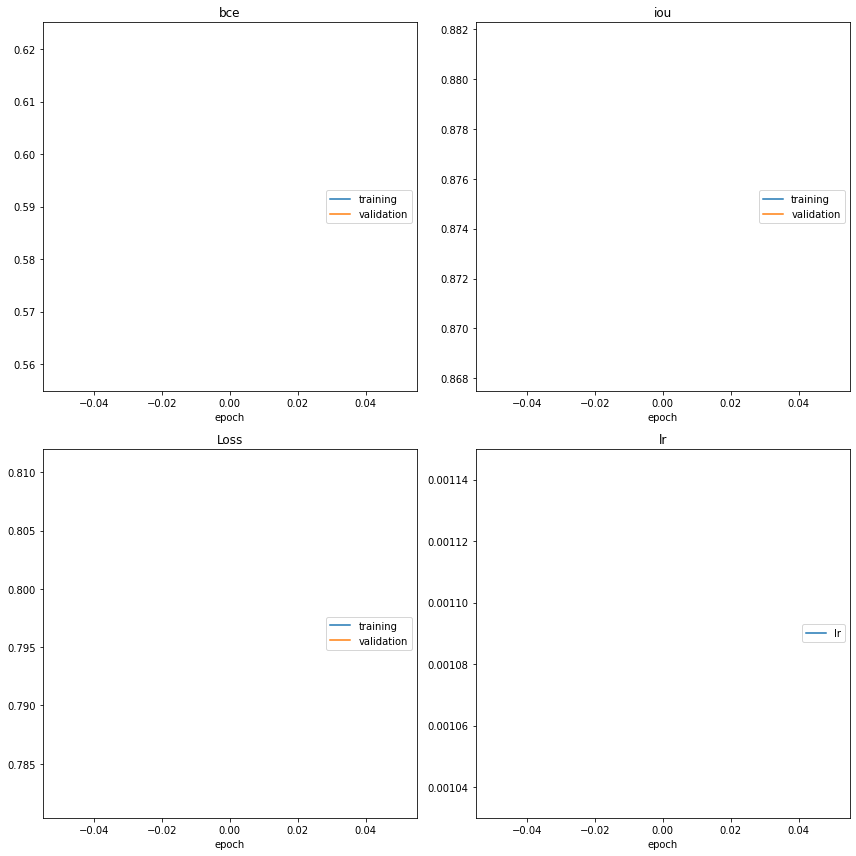

bce
	training         	 (min:    0.622, max:    0.622, cur:    0.622)
	validation       	 (min:    0.558, max:    0.558, cur:    0.558)
iou
	training         	 (min:    0.882, max:    0.882, cur:    0.882)
	validation       	 (min:    0.868, max:    0.868, cur:    0.868)
Loss
	training         	 (min:    0.811, max:    0.811, cur:    0.811)
	validation       	 (min:    0.782, max:    0.782, cur:    0.782)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)


In [ ]:
# Define network

net = CNN(channels_input    = 10,
          height_input      = 10,
          width_input       = 10,
          output_activation = nn.Sigmoid,
          hidden_activation = nn.SELU,
          batch_norm        = True,
          parameters        = [
                  {'out_channels':50,'kernel_size':3,'stride':1},
                  {'out_channels':100,'kernel_size':2,'stride':1},
                  {'out_channels':150,'kernel_size':2,'stride':1},
                  {'out_channels':200,'kernel_size':1,'stride':1},
          ],
          mean              = train_x.mean(axis=0),
          std               = train_x.std(axis=0))
net = net.to(device)

# Train the network

bce_criterion = nn.BCELoss()
iou_criterion = IoULoss()
pja_criterion = PowerJaccard(power=1.75)

if torch.cuda.is_available():
    bce_criterion = bce_criterion.cuda()
    iou_criterion = iou_criterion.cuda()
    pja_criterion = pja_criterion.cuda()

metrics = {'bce' : bce_criterion,
           'iou' : iou_criterion}      

loss    = pja_criterion

optimizer = optim.Adam(net.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                              base_lr        = 0.0001, 
                                              max_lr         = 0.01, 
                                              step_size_up   = 10,
                                              mode           = 'triangular2',
                                              cycle_momentum = False, # For Adam
                                              verbose        = False)

early_stopping = EarlyStopping(tolerance = 10,min_delta = 0.001)

epochs = 60

training(net            = net,
         train_loader   = trainloader,
         valid_loader   = validloader,
         epochs         = epochs,
         loss           = loss,
         optimizer      = optimizer,
         scheduler      = scheduler,
         metrics        = metrics,
         early_stopping = early_stopping)


## Threshold optimization

In [ ]:
def getOutput(model,loader,device=None):
    """
        From a model, get the output with data augmentation average
    """
    outputs = torch.zeros_like(valid_x_tensor)
    idx = 0
    for data in tqdm(loader):
        inputs = data[0]
        if device is not None:
            inputs = inputs.to(device)
        with torch.no_grad():
            outputs[idx:idx+inputs.shape[0]] = AveragePredictions(model,inputs)
        idx += inputs.shape[0]
    return outputs



In [ ]:
# Find optimal threshold for all layers #
def findThresh(N,outputs,valid_y):
    """
        From an output numpy array and the targets, 
        optimize the threshold globally
    """
    xs,ys = np.zeros(N),np.zeros(N)
    for i,p in enumerate(tqdm(np.linspace(0,100,N))):
        xs[i] = np.percentile(outputs, p)
        ys[i] = binary_iou(outputs>=xs[i], valid_y)

    max_single_iou = np.max(ys)
    opt_thresh = xs[np.argmax(ys)]
    plt.plot(xs,ys, label=f'Max IOU={max_single_iou:.3f} at cut of {opt_thresh:.3f}')
    plt.ylabel('IOU')
    plt.xlabel('Cut')
    plt.legend()
    plt.show()
    print (f'Optimal cut = {opt_thresh:.3f} -> Gives max IOU = {max_single_iou:.3f}')
    return max_single_iou,opt_thresh


In [ ]:
def getPredictions(output,thresh):
    """
        Return the class predictions (0s or 1s) based on the output (numpy array) and the thresholds
        thresholds can be a number (global threshold), or a list/array/tensor of thresholds per layer
    """
    if isinstance(thresh,float):
        return output >= thresh
    elif isinstance(thresh,list) or isinstance(thresh,tuple) or isinstance(thresh,np.ndarray) or isinstance(thresh,torch.tensor):
        class_pred = copy.deepcopy(outputs)
        assert class_pred.shape[1] == len(thresh)
        for i in range(len(thresh)):
            class_pred[:,i,:,:] = outputs[:,i,:,:] >= thresh[i]
        return class_pred
    else:
        raise RuntimeError(f'Unknown type {type(thresh)}')

In [ ]:
def findThreshes(N,outputs,valid_y,initial_thresh):
    """
        Optimize the thresholds per layer, using as intial value 
        the globally optimized value
    """
    # Initialize #
    initial_iou = binary_iou(getPredictions(outputs,initial_thresh).numpy(), valid_y)
    N_layers = valid_y.shape[1]
    opt_threshes = [initial_thresh]*N_layers
    max_multiple_ious = [0]*N_layers
    
    # Run through layers #
    for z in range(N_layers):
        print (f'Layer {z}')
        # Make the best prediction we currently know #
        class_preds = getPredictions(outputs,opt_threshes).numpy()
        for i,t in enumerate(opt_threshes):
            print (f'\tThreshold of layer {i:3d} = {t:0.5f}')
        print (f'  Before optimization IOU = {initial_iou:.5f}')
        # Produce scanned values #
        xs,ys = np.zeros(N),np.zeros(N)
        for i,p in enumerate(tqdm(np.linspace(0,100,N))):
            xs[i] = np.percentile(outputs[:,z,:,:], p)
            class_preds[:,z,:,:] = outputs[:,z,:,:] >= xs[i]
            ys[i] = binary_iou(class_preds, valid_y)
        # Plot and find best #
        max_iou_layer = np.max(ys)
        layer_opt_thresh = xs[np.argmax(ys)]
        class_preds[:,z,:,:] = outputs[:,z,:,:] >= layer_opt_thresh
        print (f'  After optimization IOU = {binary_iou(class_preds, valid_y):.5f}')
        print (f'  New cut for layer {z} = {layer_opt_thresh:.5f}')
        plt.plot(xs,ys, label=f'Max IOU={max_iou_layer:.5f} at cut of {layer_opt_thresh:.5f}')
        plt.ylabel('IOU')
        plt.xlabel('Cut')
        plt.legend()

        max_iou_current = binary_iou(class_preds, valid_y)
        print (f'Layer {z} : optimal cut = {layer_opt_thresh:.5f} -> Gives max IOU = {max_iou_current:.5f}')
        plt.show()
        opt_threshes[z] = layer_opt_thresh
        max_multiple_ious[z] = max_iou_current

    opt_threshes = np.array(opt_threshes)
    class_preds = np.copy(outputs)
    print ('Final thresholds : ')

    for i,t in enumerate(opt_threshes):
        print (f'\tThreshold of layer {i:3d} = {t:0.5f}')
        class_preds[:,i,:,:] = outputs[:,i,:,:] >= t
    IOU_final = binary_iou(class_preds, valid_y)
    print ('Final IOU : ', IOU_final)
    
    fig, axs = plt.subplots(1,2,figsize=(16,9))

    axs[0].plot(np.arange(1,11),opt_threshes,label='Per layer',color='b')
    axs[0].axhline(initial_thresh,label='Global threshold',color='r')
    axs[0].legend()
    axs[0].set_xlabel('Layer #')
    axs[0].set_ylabel('Optimal threshold')

    axs[1].plot(np.arange(1,11),max_multiple_ious,label='Per layer',color='b')
    axs[1].axhline(initial_iou,label='Global threshold',color='r')
    axs[1].legend()
    axs[1].set_xlabel('Layer #')
    axs[1].set_ylabel('Max IOU')

    plt.show()
    
    if  max_multiple_ious[-1] < initial_iou:
        print ('Warning : not better so will take globally optimized threshold')
        opt_threshes = [initial_thresh]*N_layers
        IOU_final = initial_iou 
        print (opt_threshes)
    
    return IOU_final, opt_threshes


In [ ]:
print (net)
# Investigate the spread of performances #
print ('Producing output')
outputs = getOutput(net,validloader,device)
N = 1001 # Number of optimization steps

# Find global optimal threshold #
print ('Running optimization of global threshold')
IOU, opt_thresh = findThresh(N,outputs.numpy(),valid_y)

# Find optimized threshold per layer #
print ('Running optimization of per-layer thresholds')
IOU, opt_threshes = findThreshes(N,outputs,valid_y,opt_thresh)

# Produce values #
losses = []
IOUs = []
for i in tqdm(range(valid_y_tensor.shape[0])):
    losses.append(1-loss(outputs[i:i+1],valid_y_tensor[i:i+1]))
    class_pred = getPredictions(outputs[i:i+1],opt_thresh).numpy()
    IOUs.append(binary_iou(class_pred, valid_y[i:i+1]))
    
# Plots #
plt.hist(losses,bins=50,alpha=0.5,label='Per validation sample')
plt.axvline(1-loss(outputs,valid_y_tensor),label='Whole validation set')
plt.xlabel('1 - loss')
plt.legend()
plt.show()

plt.hist(IOUs,bins=50,alpha=0.5,label='Per validation sample')
tot_IOU = binary_iou(getPredictions(outputs,opt_thresh).numpy(), valid_y)
plt.axvline(tot_IOU,label='Whole validation set')
plt.xlabel('IOU')
plt.legend()
plt.show()
plt.close()


# Plot predictions at different performance level #
IOUs = np.array(IOUs)

for IOU in np.r_[0.05:1.01:0.05]:
    # Find the index of the prediction #
    idx = np.argmin(np.abs(IOUs-IOU))
    # plot #
    print (f'IOU = {IOUs[idx]:.3f}')
    plot(valid_x[idx], valid_y[idx], getPredictions(outputs[idx:idx+1],opt_thresh)[0], log=True, clip=0.1)


# Study of the encoder

In [ ]:
# Load the CNN #

outputs = getOutput(net,validloader,device)

IOU, opt_thresh = findThresh(101,outputs.numpy(),valid_y)

# Produce values #
IOUs = []
for i in tqdm(range(valid_y_tensor.shape[0])):
    class_pred = getPredictions(outputs[i:i+1],opt_thresh).numpy()
    IOUs.append(binary_iou(class_pred, valid_y[i:i+1]))

IOUs = np.array(IOUs)
plt.hist(IOUs,bins=50,alpha=0.5,label='Per validation sample')
tot_IOU = binary_iou(getPredictions(outputs,opt_thresh).numpy(), valid_y)
plt.axvline(tot_IOU,label='Whole validation set')
plt.xlabel('IOU')
plt.legend()
plt.show()
plt.close()

IOU_to_plot = [0.5,0.8,0.9,1.]
idxs = np.unique(np.array([np.argmin(abs(IOUs-IOU)) for IOU in IOU_to_plot]))

net = net.cpu()

for i in idxs:
    print (f'Plotting idx {i} with IOU={IOUs[i]:.3f}')
    x = valid_x_tensor[i:i+1]
    t = valid_y_tensor[i:i+1]
    y = net.encoder(x)[0].detach().numpy()

    plot(x[0], t[0], outputs[i]>opt_thresh, log=True, clip=0.1)
        
    dim = y.shape[1]
    cols = dim // int(math.sqrt(dim))
    rows = cols + 1
    
    fig,axs = plt.subplots(rows,cols,figsize=(25,16))
    
    for i in tqdm(range(dim)):
        row = i // rows
        col = i % cols
        #print (f'sample {i} : col = {col}/{cols}, row = {row}/{rows}')
        axs[row,col] = sns.heatmap(y[0,i,:,:],ax=axs[row,col])
    plt.show()


## Submission prep

Let's say we are happy with our solution and we want to submit predictions for the test data. We first need to load the data, score it, and then save our predictions to a new file.

In [ ]:
with h5py.File(DATA/'test.h5', 'r') as h5:
    test_x = h5['x0'][()]

In [ ]:
test_x.shape

We compute our predictions just like we did on the validation data

In [ ]:
with torch.no_grad():
    test_output = AveragePredictions(net,torch.from_numpy(test_x).to(device)).cpu().detach().numpy()
test_preds = getPredictions(test_output,opt_threshes)

print (test_preds.shape)

In [ ]:
# plot one test 
idx = 1
plot(test_preds[idx], test_preds[idx])

To submit predictions, please save them to a HDF5 file using the function below. The file name should use the format `[your_full_name]_test_preds.h5`. Ypu can also include an option ID number in case you submit multiple times. Your final score, and score for the Friday announcements, will be computed on your submission with the highest ID number.

In [ ]:
# make save subdirectory #
idx = 0

subdir_base = os.path.join(DATA,'predictions','ID{idx}')
subdir = subdir_base.format(idx=idx)

while  (os.path.exists(subdir) and len(os.listdir(subdir) ) > 0):
    idx += 1
    subdir = subdir_base.format(idx=idx)
    
print (f'Current subdirectory : {subdir}')
if not os.path.exists(subdir):
    os.makedirs(subdir)
subname = os.path.join(subdir,f'FLORIAN_BURY_ID{idx}_test_preds.h5')

In [ ]:
# Save DNN  #
torch.save(net, os.path.join(subdir,'model.pt'))

# Save thresholds and performances #
with open(os.path.join(subdir,'parameters.npy'), 'wb') as f:
    np.savez(f,thresholds=opt_threshes,iou=best_iou)
with open(os.path.join(subdir,'iou.txt'), 'w') as f:
    f.write(str(best_iou))

In [ ]:
with h5py.File(subname, 'w') as h5:
    h5.create_dataset("preds", data=test_preds.astype("int"), dtype="int", compression='lzf')
print (f"Produced {subname}")

## Compare all models 

In [131]:
results = {}
for subdir in sorted(glob.glob(os.path.join(DATA,'predictions','*'))):
    # Make paths #
    idx = os.path.basename(subdir)
    model_path = os.path.join(subdir,'model.pt')
    iou_path = os.path.join(subdir,'iou.txt')
    
    # Check if content is there #
    if not os.path.exists(model_path) and not os.path.exists(iou_path):
        continue
    
    # Recover iou and model #
    with open(iou_path,'r') as handle:
        iou = float(handle.read())
    model = torch.load(model_path)
    results[iou] = (idx,model)
    
# Show best models #
for i,iou in enumerate(reversed(sorted(results.keys())),1):
    print ('-'*60)
    print (f'Model number {i} (idx = {results[iou][0]}) -> iou = {iou:.3f}')
    print (results[iou][1])

------------------------------------------------------------
Model number 1 (idx = ID26) -> iou = 0.793
CNN(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): Conv2d(10, 50, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU(inplace=True)
      (2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(50, 100, kernel_size=(2, 2), stride=(1, 1))
      (4): SELU(inplace=True)
      (5): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(100, 150, kernel_size=(2, 2), stride=(1, 1))
      (7): SELU(inplace=True)
      (8): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Conv2d(150, 200, kernel_size=(1, 1), stride=(1, 1))
      (10): SELU(inplace=True)
      (11): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): ConvTranspose2d(200, 150, kernel_siz

In [ ]:
# Train several networks with boosting class


bce_criterion = nn.BCELoss()
iou_criterion = IoULoss()
pja_criterion = PowerJaccard(power=1.75)

if torch.cuda.is_available():
    bce_criterion = bce_criterion.cuda()
    iou_criterion = iou_criterion.cuda()
    pja_criterion = pja_criterion.cuda()

metrics = {'bce' : bce_criterion,
           'iou' : iou_criterion}  

loss    = pja_criterion

boostedNet = BoostedCNN(x              = train_x_tensor,
                        y              = train_y_tensor,
                        batch_size     = batch_size,
                        method         = 'sample',
                        mode           = "W",
                        device         = device)


# Start training #
N_boost = 50
epochs = 60

for ib in range(N_boost):
    net = getnet()
    
    optimizer = optim.Adam(net.parameters(), lr=0.01)

    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  base_lr        = 0.0001, 
                                                  max_lr         = 0.01, 
                                                  step_size_up   = 10,
                                                  mode           = 'triangular2',
                                                  cycle_momentum = False, # For Adam
                                                  verbose        = False)

    early_stopping = EarlyStopping(tolerance = 10,min_delta = 0.001)

    training(net            = net,
             train_loader   = boostedNet.getLoader(),
             valid_loader   = validloader,
             epochs         = epochs,
             loss           = loss,
             optimizer      = optimizer,
             scheduler      = scheduler,
             metrics        = metrics,
             early_stopping = early_stopping)
    
    boostedNet.addNet(copy.deepcopy(net))
    
    
boostedNet.printStatus()

In [ ]:
outputs_weighted = torch.zeros_like(valid_x_tensor)
total_weight = 0.
IOU_models = []
for i in range(len(boostedNet.nets)):
    print (f'Model {i+1}')
    net = boostedNet.nets[i]
    net = net.to(device)
    beta = boostedNet.betas[i]
    #print (net)
    print ('Producing outputs')
    outputs = getOutput(net,validloader,device)
    
    outputs_numpy = outputs.cpu().detach().numpy()
    plt.hist(outputs_numpy.flatten(),bins=100,range=[outputs_numpy.min(),outputs_numpy.max()])
    plt.yscale('log')
    plt.show()
    plt.close()
    
    print ('Finding best IOU')
    IOU_models.append(findThresh(101,outputs_numpy,valid_y))
    
    factor = torch.log(1/beta)
    outputs_weighted += outputs * factor
    total_weight += factor
    
outputs_weighted /= total_weight

print ('Boosted DNN')
outputs_weighted_numpy = outputs_weighted.cpu().detach().numpy()
plt.hist(outputs_weighted_numpy.flatten(),bins=100,range=[outputs_weighted_numpy.min(),outputs_weighted_numpy.max()])
plt.yscale('log')
plt.show()
plt.close()
IOU_boosted = findThresh(101,outputs_weighted_numpy,valid_y)

plt.plot(IOU_models)
plt.xlabel("Models")
plt.ylabel("IOU")
plt.axhline(y = IOU_boosted, color = 'r', linestyle = '-')
plt.show()
plt.close()


# Test of split training 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [00:03<00:00, 177.58it/s]


torch.Size([679224, 10, 10, 10]) torch.Size([679224, 10, 10, 10]) torch.Size([679224, 10, 10, 10])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 679224/679224 [01:02<00:00, 10852.06it/s]


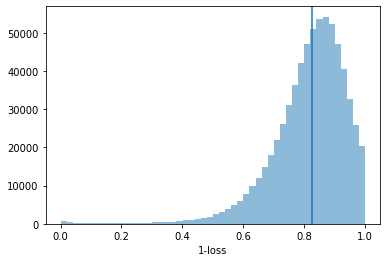

In [65]:
# Load the CNN #
idx = 26

subdir = os.path.join(DATA,'predictions',f'ID{idx}')

net = torch.load(os.path.join(subdir,'model.pt'))

i = 0

train_output = net.predict(train_x_tensor.to(device),batch_size=1000).cpu()

losses = []
for i in tqdm(range(train_output.shape[0])):
    losses.append(1-loss(train_output[i:i+1],train_y_tensor[i:i+1]))
plt.hist(losses,bins=50,alpha=0.5)
tot_loss = 1-loss(train_output,train_y_tensor)
plt.axvline(tot_loss)
plt.xlabel("1-loss")
plt.show()
plt.close()

In [29]:



def run_training(net,epochs,loader):

    bce_criterion = nn.BCELoss()
    iou_criterion = IoULoss()
    pja_criterion = PowerJaccard(power=1.75)


    if torch.cuda.is_available():
        bce_criterion = bce_criterion.cuda()
        iou_criterion = iou_criterion.cuda()
        pja_criterion = pja_criterion.cuda()

    metrics = {'bce' : bce_criterion,
               'iou' : iou_criterion}
        
    loss    = pja_criterion

    if torch.cuda.is_available():
        net = net.cuda()
    
    optimizer = optim.Adam(net.parameters(), lr=0.01)

    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  base_lr        = 0.0001, 
                                                  max_lr         = 0.01, 
                                                  step_size_up   = 10,
                                                  mode           = 'triangular2',
                                                  cycle_momentum = False, # For Adam
                                                  verbose        = False)

    early_stopping = EarlyStopping(tolerance = 10,min_delta = 0.001)
    training(net            = net,
             train_loader   = loader,
             valid_loader   = validloader,
             epochs         = epochs,
             loss           = loss,
             optimizer      = optimizer,
             scheduler      = scheduler,
             metrics        = metrics,
             early_stopping = early_stopping)


In [68]:

def getnet(params):
    net = CNN(channels_input    = 10,
              height_input      = 10,
              width_input       = 10,
              output_activation = nn.Sigmoid,
              hidden_activation = nn.SELU,
              batch_norm        = True,
              parameters        = params,
              mean              = train_x.mean(axis=0),
              std               = train_x.std(axis=0))
    #net = net.to(device)
    return net

params = [
    {'out_channels': 50, 'kernel_size':  3, 'stride': 1},
    {'out_channels': 100, 'kernel_size': 1, 'stride': 1},
    {'out_channels': 150, 'kernel_size': 2, 'stride': 1},
    {'out_channels': 150, 'kernel_size': 2, 'stride': 1},
]




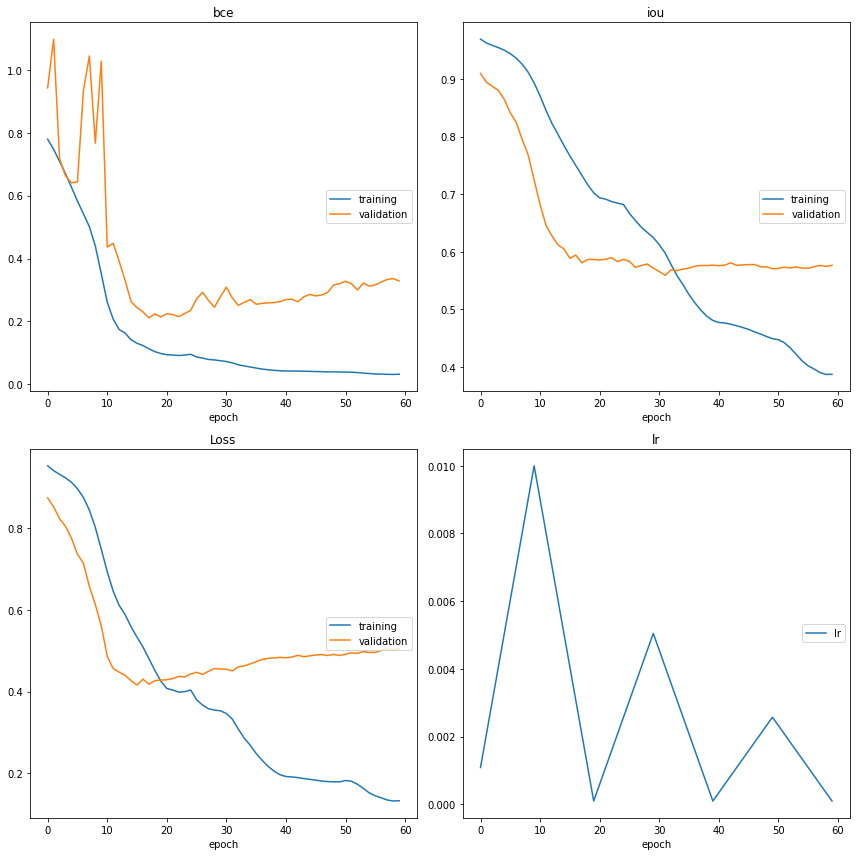

bce
	training         	 (min:    0.031, max:    0.780, cur:    0.032)
	validation       	 (min:    0.211, max:    1.098, cur:    0.328)
iou
	training         	 (min:    0.387, max:    0.969, cur:    0.387)
	validation       	 (min:    0.559, max:    0.910, cur:    0.576)
Loss
	training         	 (min:    0.132, max:    0.953, cur:    0.133)
	validation       	 (min:    0.416, max:    0.875, cur:    0.504)
lr
	lr               	 (min:    0.000, max:    0.010, cur:    0.000)
Finished Training


In [80]:
# Make loader of below avg loss #

badnet = getnet(params)

print (f'Training on {train_x_tensor[idx].shape[0]}/{train_x_tensor.shape[0]} [{train_x_tensor[idx].shape[0]/train_x_tensor.shape[0]*100:5.2f}%]')
train_bad_dataset = CustomDataset(train_x_tensor[idx],
                              train_y_tensor[idx],
                              device=device)

trainbadloader = torch.utils.data.DataLoader(train_bad_dataset,
                                          batch_size      = batch_size,
                                          shuffle         = True)

run_training(badnet,60,trainbadloader)


/scratch/fbury/33705349/ipykernel_4668/83174504.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  losses = torch.tensor(losses)


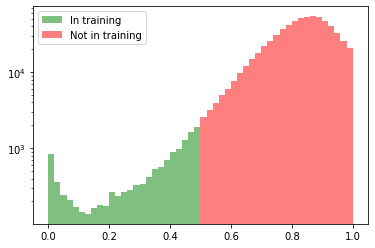

In [78]:

    
net = getnet(params)

run_training(net,100,trainloader)

outputs = getOutput(net,validloader,device)
    
outputs_numpy = outputs.cpu().detach().numpy()


losses = torch.tensor(losses)
idx = losses < 0.5

plt.hist(losses[idx],color='g',alpha=0.5,bins=50,range=[0,1],label='In training')
plt.hist(losses[~idx],color='r',alpha=0.5,bins=50,range=[0,1],label='Not in training')
plt.legend()
plt.yscale('log')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:31<00:00,  3.18it/s]


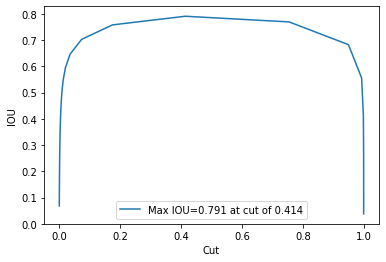

Optimal cut = 0.414 -> Gives max IOU = 0.791


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  2.99it/s]


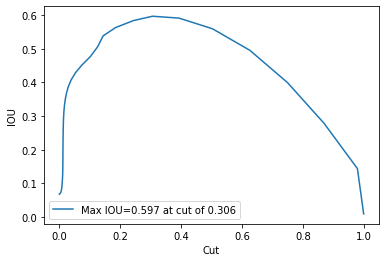

Optimal cut = 0.306 -> Gives max IOU = 0.597


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21226/21226 [00:10<00:00, 2092.96it/s]


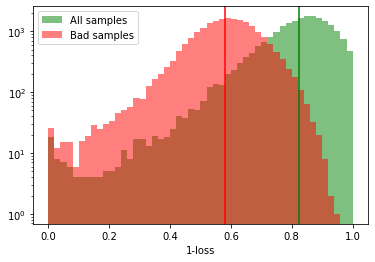

In [81]:
outputs_all = getOutput(net,validloader)
outputs_bad = getOutput(badnet,validloader)

IOU_all, thresh_all = findThresh(101,outputs_all.detach().numpy(),valid_y)
IOU_bad, thresh_bad = findThresh(101,outputs_bad.detach().numpy(),valid_y)

losses_all = []
losses_bad = []
for i in tqdm(range(valid_y.shape[0])):
    losses_all.append(1-loss(outputs_all[i:i+1],valid_y[i:i+1]))
    losses_bad.append(1-loss(outputs_bad[i:i+1],valid_y[i:i+1]))
plt.hist(losses_all,bins=50,alpha=0.5,range=[0,1],color='g',label='All samples')
plt.hist(losses_bad,bins=50,alpha=0.5,range=[0,1],color='r',label='Bad samples')
tot_loss_all = 1-loss(outputs_all,valid_y)
tot_loss_bad = 1-loss(outputs_bad,valid_y)

plt.axvline(tot_loss_all,color='g')
plt.axvline(tot_loss_bad,color='r')
plt.legend()
plt.yscale('log')
plt.xlabel("1-loss")
plt.show()
plt.close()

for frac in np.linspace(0,1,11):
    print (f'{frac:3.2f} all + {1-frac:3.2f} bad')
    outputs_mix = outputs_all * frac + outputs_bad * (1-frac)
    findThresh(101,outputs_mix.detach().numpy(),valid_y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [06:39<00:00,  2.00s/it]


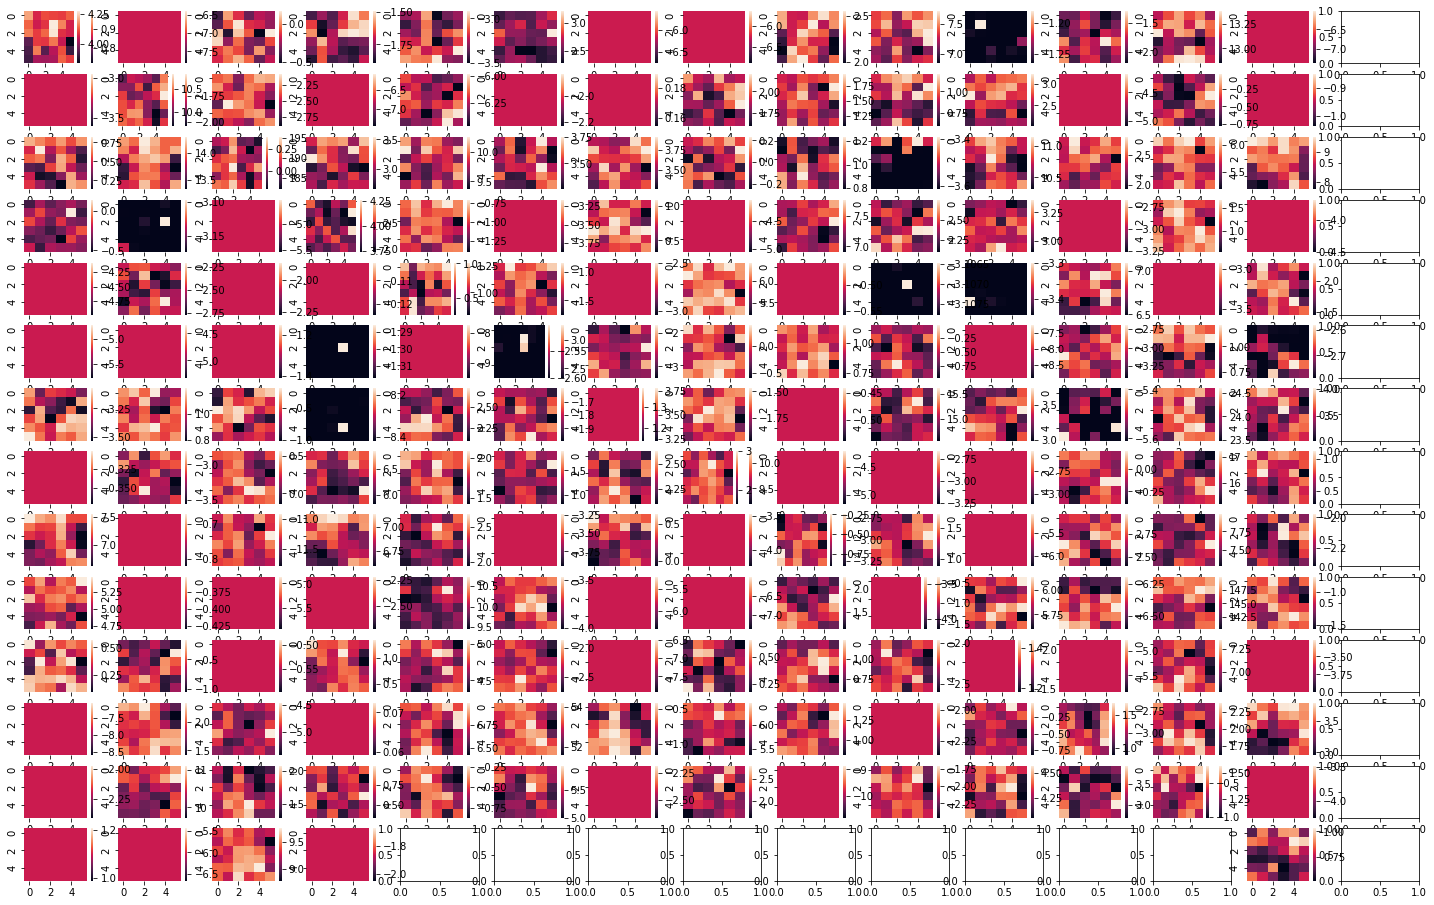